In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

import matplotlib as mpl

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,12)))
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)

dftab=pd.read_pickle('dfs/df_run_01_land_dry_delta_tab.pkl')
df=pd.read_pickle('dfs/df_run_01_land_dry.pkl')


# dftab=pd.read_pickle('dfs/df_run_01_land_delta_tab.pkl')
# df=pd.read_pickle('dfs/df_run_01_land.pkl')

In [108]:
def fit_thalf(t,y,C,ax=False):
    y0 = C-y
    ly = np.log(y0)
    K, A_log = np.polyfit(t, ly, 1)
    A = np.exp(A_log)
    thalf=-np.log(2)/K
    y0f=np.exp(A_log+t*K)
    
    if ax:
        ax.plot(t*24,y0)
        ax.plot(t*24,y0f,'--')
        ax.grid(True)
        ax.set_title('t$_{lf}$='+str(tlf))
        ax.set_xlabel('t (h)')
        ax.set_ylabel('Pdef (pa)')
        ax.set_xlim((0,12))
        ax.set_ylim((10,110))
        
    return(thalf)

def get_a_coeff(dft,tlf,ax=False):
    tal=dft['t']-dft['tlf']
    dft=dft[dft.tlf.eq(tlf) & dft.r.gt(5)]
    dft=dft.query('r < rV10max*1.0')
    dft=dft.query('t - tlf < 3/24.')
    dft=dft.query('Vrcol > 0')

    m,c=np.polyfit(dft.dPdr,dft.Vrcol,1)
    
    if ax:
        ax.plot(dft.dPdr,dft.Vrcol,'.')
        ax.plot(dft.dPdr,m*dft.dPdr+c,lw=2)
        ax.set_xlim((0,0.25))
        ax.set_ylim((0,0.045))
        ax.set_title('t$_{lf}$='+str(tlf))
        ax.grid(True)
        ax.set_xlabel('dPdr')
        ax.set_ylabel('Vrcol')
    return(m)

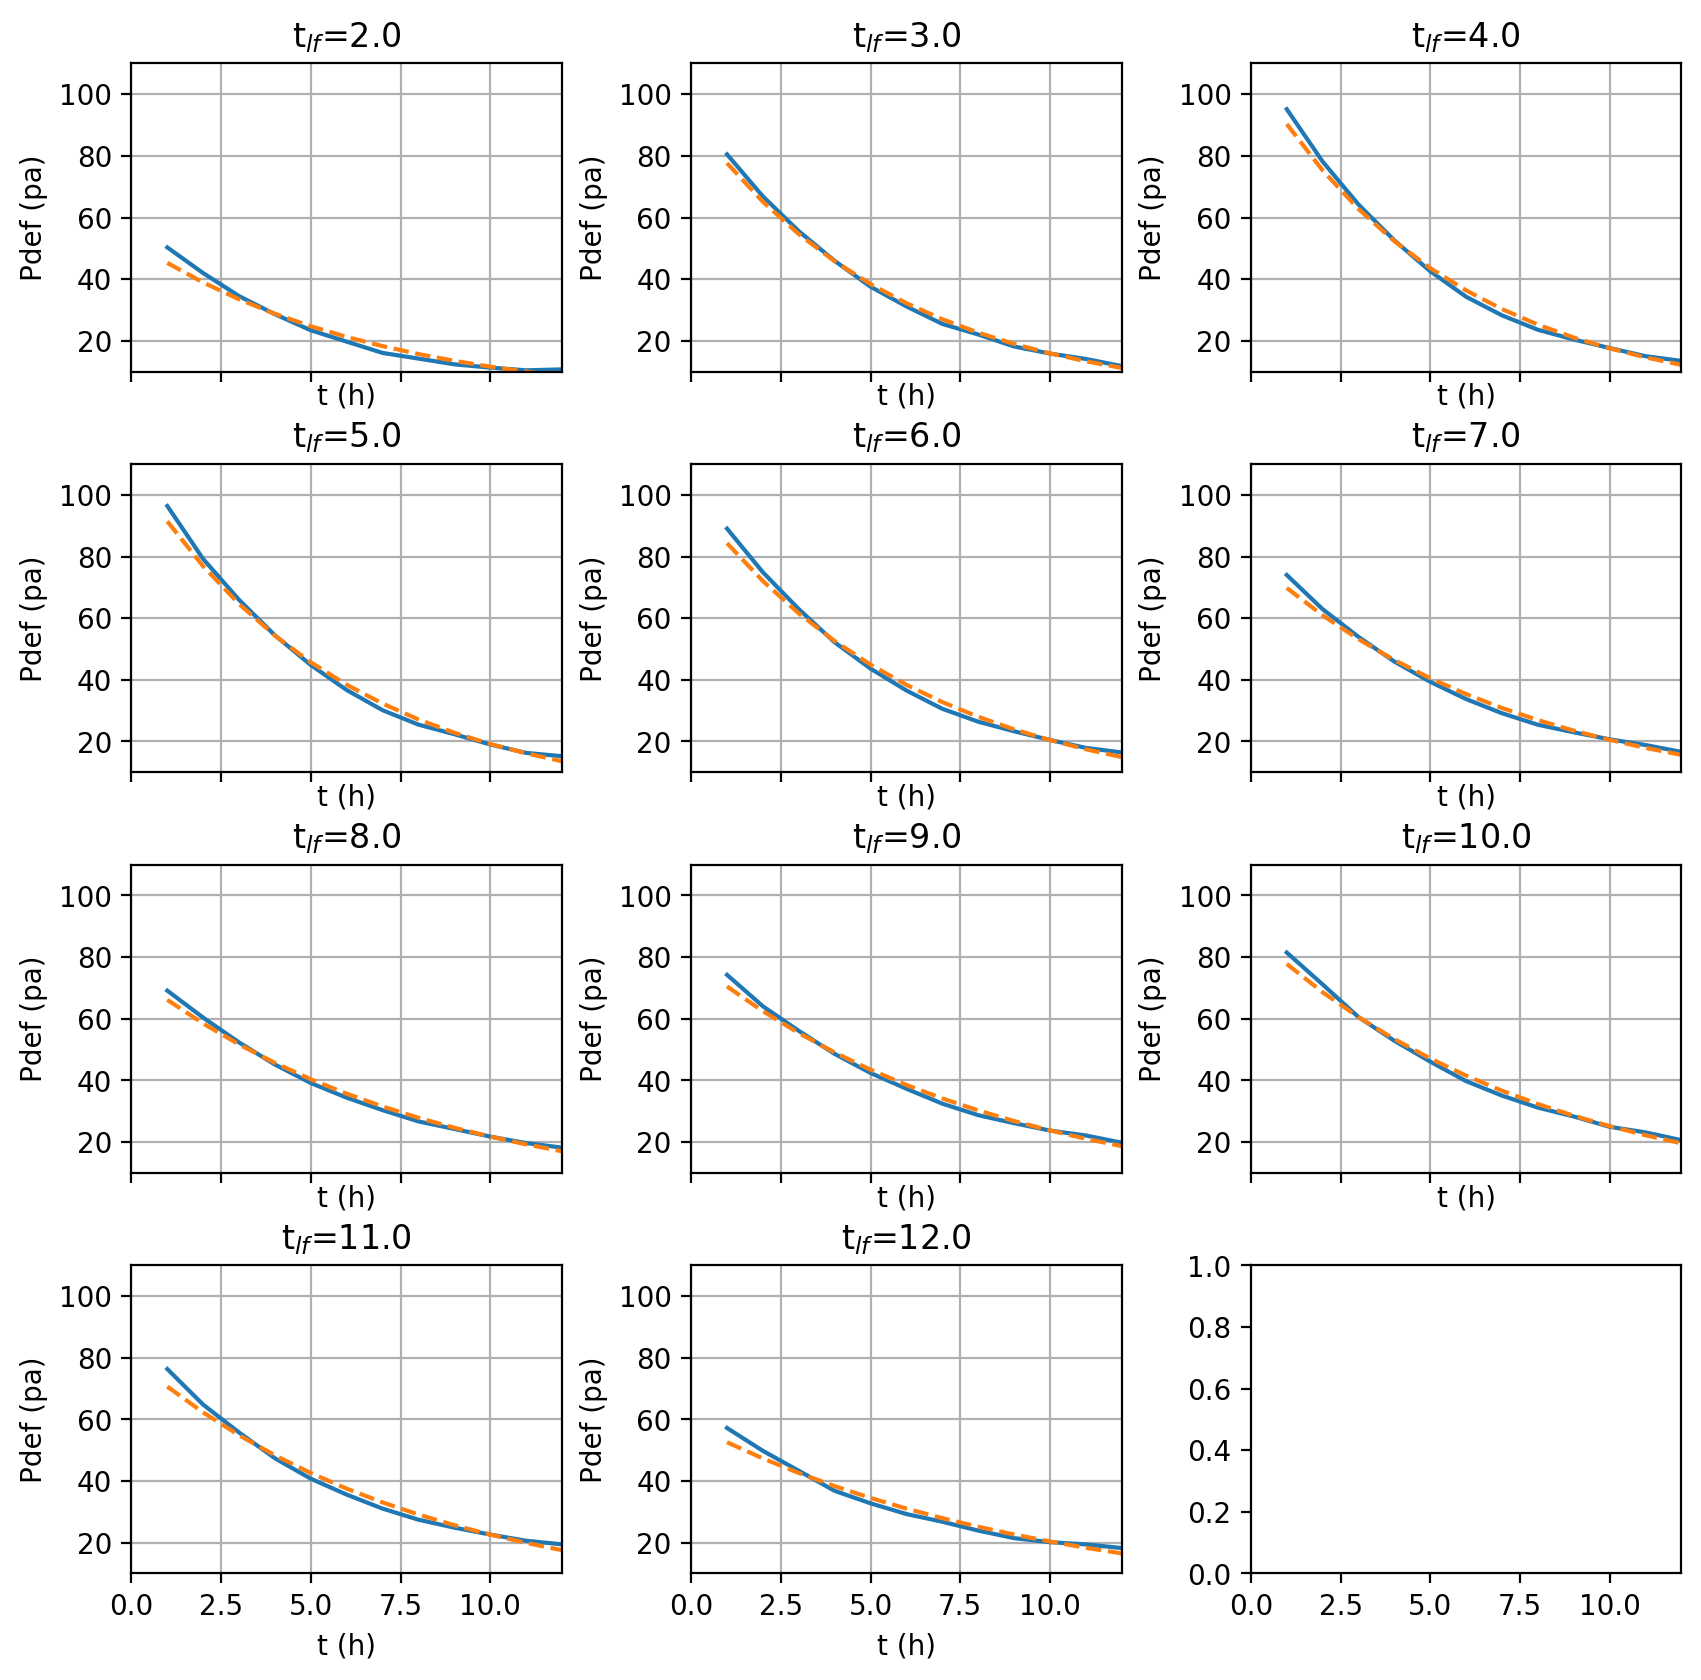

In [109]:
fig,axs=plt.subplots(4,3,sharex=True,dpi=200,figsize=(10,10))
plt.subplots_adjust(hspace=0.3,wspace=0.3)
tlfs=df.tlf.unique()
th=[]
Rmax0=[]
Pmin0=[]
Pe=1016
t0=1
for n,tlf in enumerate(tlfs):
    dftab_f=dftab[dftab.tlf.eq(tlf)]
    df_f=df[df.tlf.eq(tlf)]
    t=df_f.t-df_f.tlf
    Pmin=df_f.Pmin
    Rmax0.append(df_f.rV10max.head(1))
    Pmin0.append(df_f.Pmin.head(1))
    th.append(24*fit_thalf(t[t0:],Pmin[t0:],C=Pe,ax=axs.flat[n]))

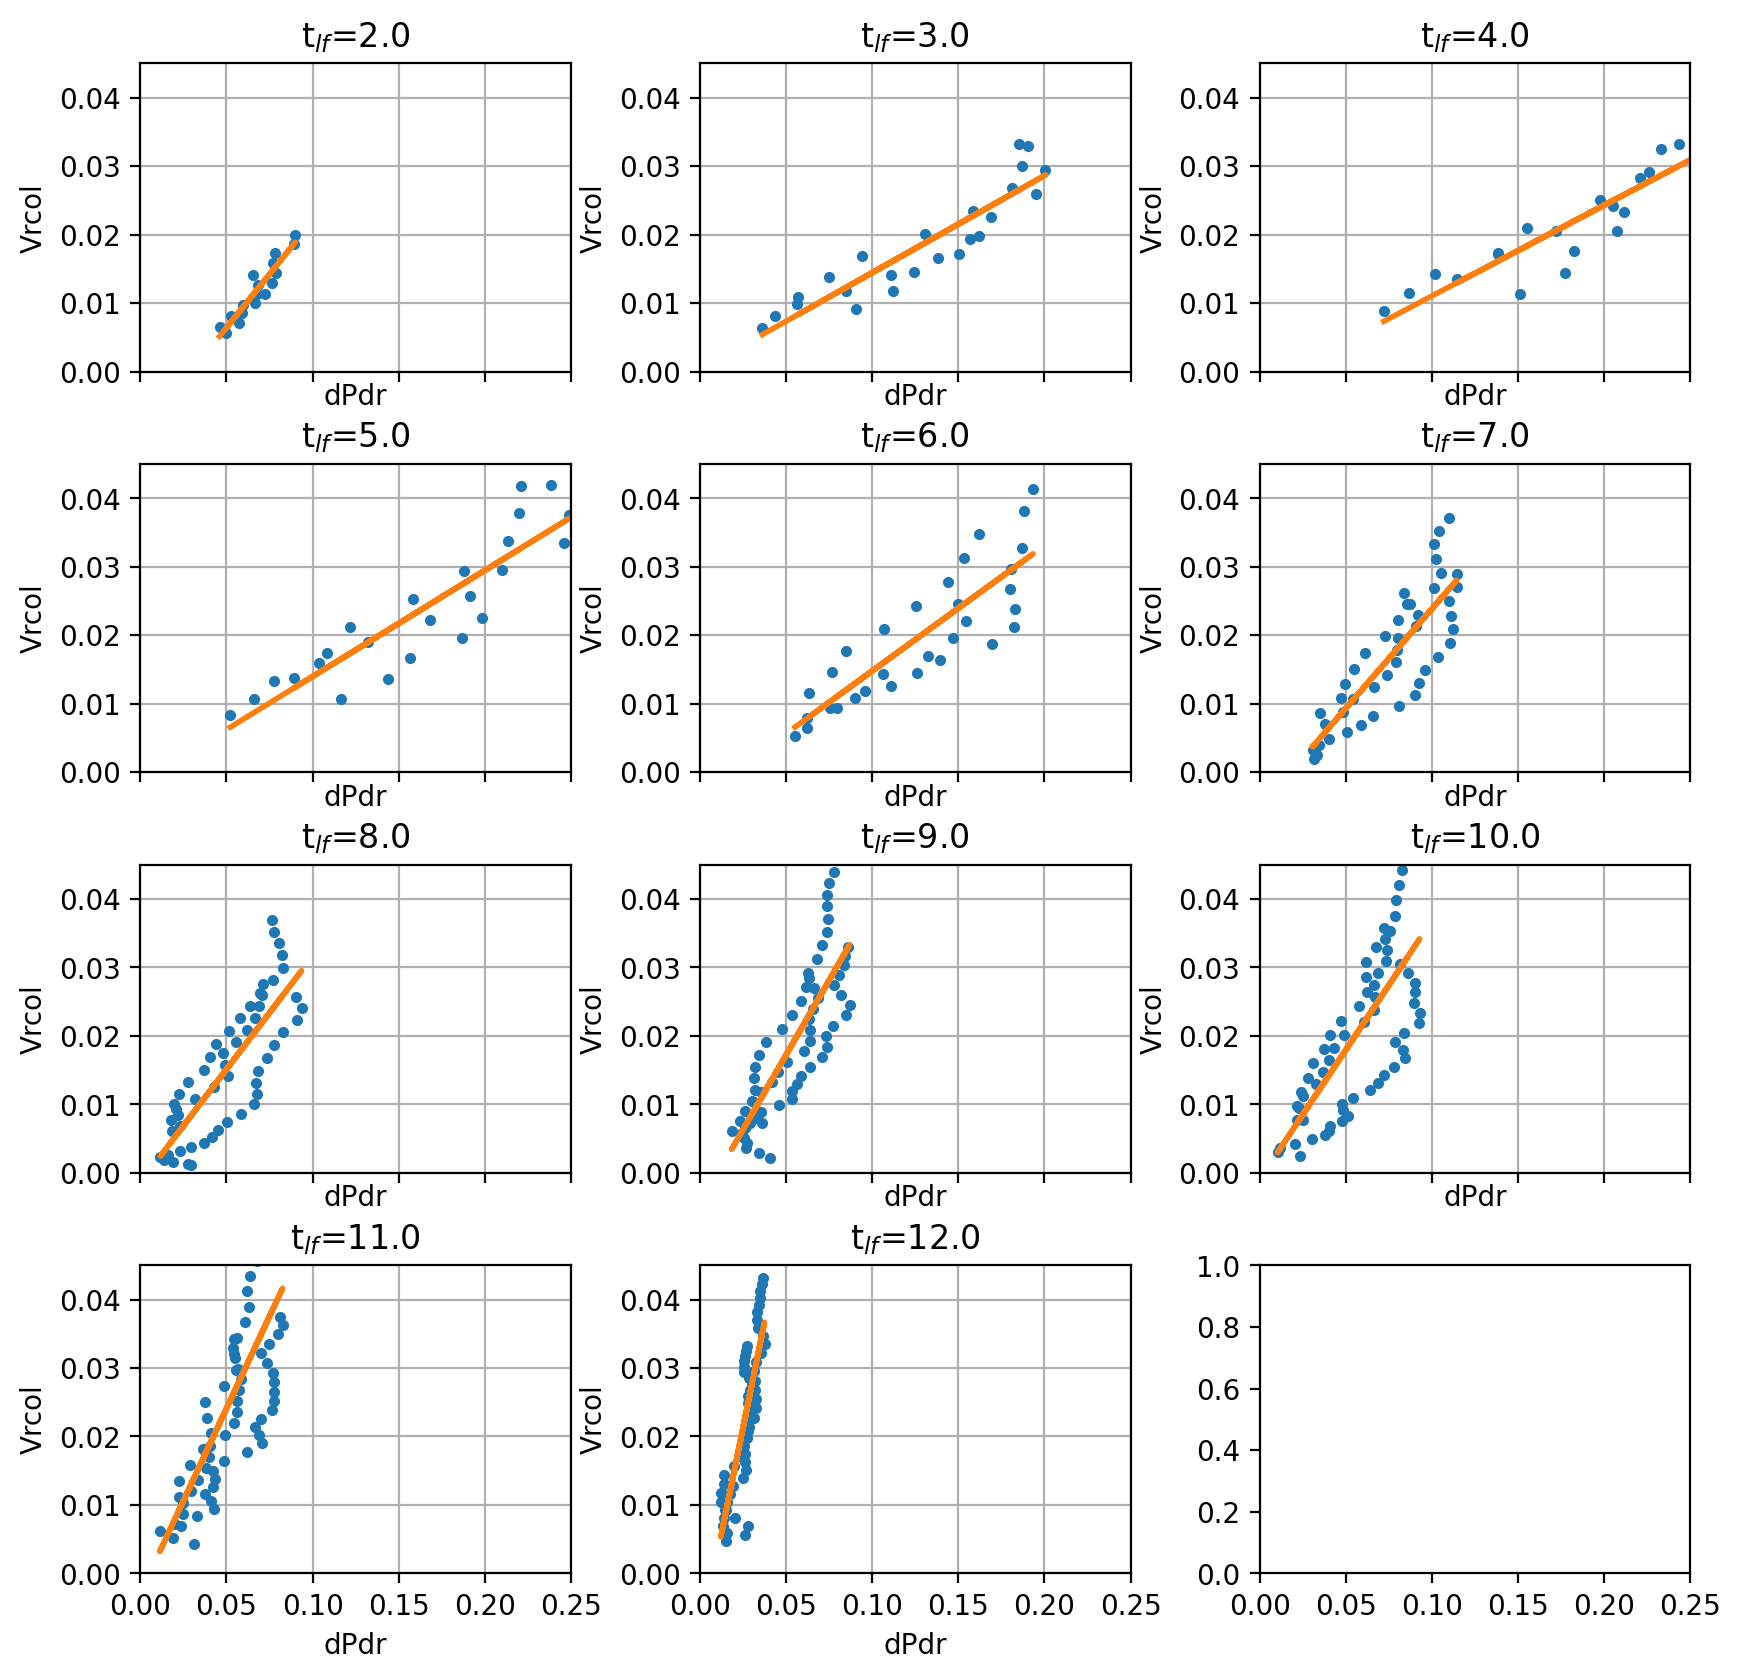

In [110]:
fig,axs=plt.subplots(4,3,sharex=True,dpi=200,figsize=(10,10))
plt.subplots_adjust(hspace=0.3,wspace=0.3)
a=[]
for n,tlf in enumerate(tlfs):
    a.append(get_a_coeff(dftab,tlf,ax=axs.flat[n]))

In [111]:
tlfs=df.tlf.unique()

def calc_thalf(rmax,a,Pe,Pd0):
    return(rmax**2/(2*a*Pe)*np.log(1+Pe/(Pe-Pd0)))

tha=[calc_thalf(Rmax*1000,a,Pe*100,(Pe-Pmin)*100) for Rmax,a,Pmin in zip (Rmax0,a,Pmin0)]
tha=[x.values for x in tha]
tha=np.concatenate(tha)/(60*60)
tha

Rmax0=[x.values for x in Rmax0]
Rmax0=np.concatenate(Rmax0)

Text(0.5, 0, 't$_{lf}$ (d)')

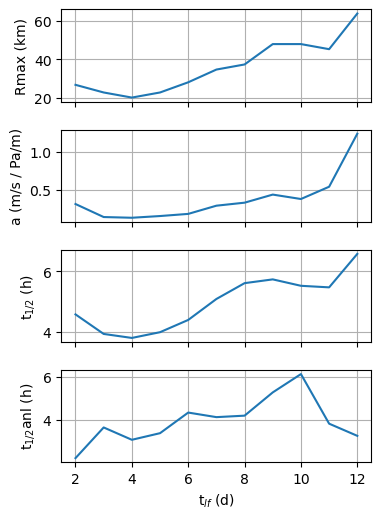

In [112]:
fig,axs=plt.subplots(4,1,sharex=True,dpi=100,figsize=(4,6))
plt.subplots_adjust(hspace=0.3,wspace=0.3)

ax=axs[0]
ax.plot(tlfs,Rmax0)
ax.grid(True)
ax.set_ylabel('Rmax (km)')

ax=axs[1]
ax.plot(tlfs,a)
ax.grid(True)
ax.set_ylabel('a (m/s / Pa/m)')

ax=axs[2]
ax.plot(tlfs,th)
ax.grid(True)
ax.set_ylabel('t$_{1/2}$ (h)')

ax=axs[3]
ax.plot(tlfs,tha)
ax.grid(True)
ax.set_ylabel('t$_{1/2}$anl (h)')
ax.set_xlabel('t$_{lf}$ (d)')

Text(0.5, 0.98, 'Dry')

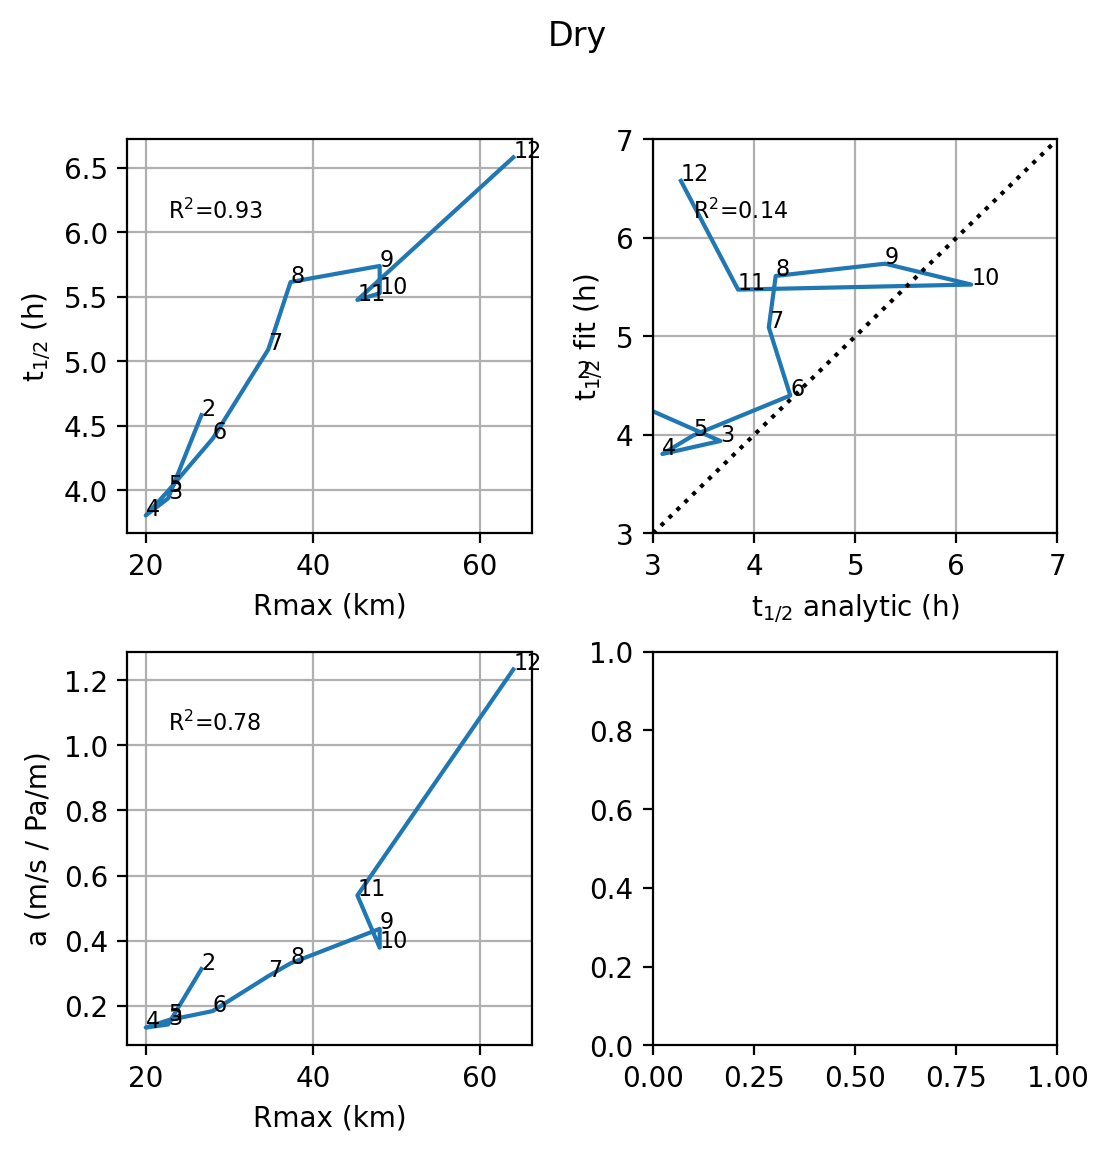

In [113]:
tlfs=df.tlf.unique()
fs=8
fig,axs=plt.subplots(2,2,dpi=200,figsize=(6,6))
plt.subplots_adjust(hspace=0.3,wspace=0.3)
ax=axs.flat[0]
ax.plot(Rmax0,th)
ax.grid(True)
ax.set_ylabel('t$_{1/2}$ (h)')
ax.set_xlabel('Rmax (km)')
for i,tlf in enumerate(tlfs):
    ax.text(Rmax0[i],th[i],round(tlf),fontsize=8)
r2=np.corrcoef(Rmax0,th)[0,1]**2
ax.text(0.1,0.8,"R$^2$={:2.2f}".format(r2),transform=ax.transAxes,fontsize=8)

ax=axs.flat[1]
ax.plot(tha,th)
axr=(3,7)
ax.plot(axr,axr,':k')
ax.set_xlim(axr)
ax.set_ylim(axr)
ax.grid(True)
ax.set_ylabel('t$_{1/2}$ fit (h)')
ax.set_xlabel('t$_{1/2}$ analytic (h)')
for i,tlf in enumerate(tlfs):
    ax.text(tha[i],th[i],round(tlf),fontsize=8)
r2=np.corrcoef(tha,th)[0,1]**2
ax.text(0.1,0.8,"R$^2$={:2.2f}".format(r2),transform=ax.transAxes,fontsize=8)


ax=axs.flat[2]
ax.plot(Rmax0,a)
ax.grid(True)
ax.set_ylabel('a (m/s / Pa/m)')
ax.set_xlabel('Rmax (km)')
for i,tlf in enumerate(tlfs):
    ax.text(Rmax0[i],a[i],round(tlf),fontsize=8)
r2=np.corrcoef(Rmax0,a)[0,1]**2
ax.text(0.1,0.8,"R$^2$={:2.2f}".format(r2),transform=ax.transAxes,fontsize=8)


plt.suptitle('Dry')